In [1]:
import sys
import torch
sys.path.append("..")

from torch.utils.data import DataLoader, TensorDataset
from pytorch_utils import *
from preprocess import *
from model_container import ModelContainer

In [2]:
resnet50 = ModelContainer(
    nnet = get_instrument_segmentation_model_base(
        Models.RESNETV50
    ),
    returns_dict = True
)

unet = ModelContainer(
    nnet = get_instrument_segmentation_model_base(
        Models.UNET
    ),
    returns_dict = False
)

input_shape = (96, 128)

custom = \
    ModelContainer(
        get_instrument_segmentation_model_base(Models.CUSTOM, shape = input_shape),
        returns_dict = False
    )

In [3]:
resnet50.load_model(torch.load("..\\pickled\\resnet50_model_full.pkl"))
unet.load_model(torch.load("..\\pickled\\unet_model_full.pkl"))
custom.load_model(torch.load("..\\pickled\\custom_model_full.pkl"))

In [4]:
resnet50_losses = torch.load("..\\pickled\\resnet50_losses_full.pkl")
unet_losses = torch.load("..\\pickled\\unet_losses_full.pkl")
custom_losses = torch.load("..\\pickled\\custom_losses_full.pkl")

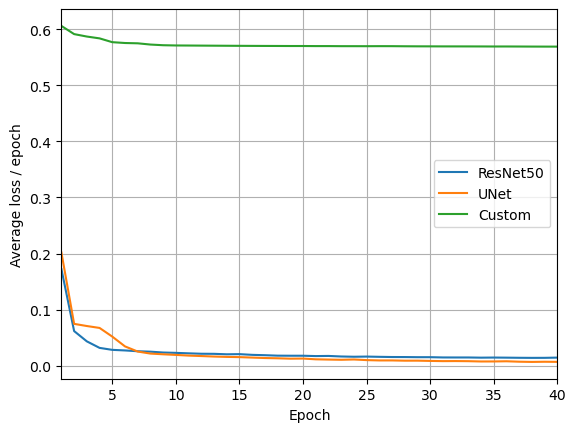

In [5]:
I = 4480 // 128 # number of samples
N = 40 # number of samples

import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(N) + 1, np.average(np.array(resnet50_losses).reshape(-1, I), axis = 1), label = "ResNet50")
plt.plot(np.arange(N) + 1, np.average(np.array(unet_losses).reshape(-1, I), axis = 1), label = "UNet")
plt.plot(np.arange(N) + 1, np.average(np.array(custom_losses).reshape(-1, I), axis = 1), label = "Custom")
plt.ylabel("Average loss / epoch")
plt.xlabel("Epoch")
plt.xlim([1, N])
plt.grid()
plt.legend()

In [6]:
np.average(np.array(custom_losses).reshape(-1, I), axis = 1)[-1]

0.5688898835863386

In [7]:
input_, output_ = load_endovis_videos(DatasetType.TESTING)

# for some reason, two of the videos for the output had an extra frame.
# removing the last frame of said videos in order to somewhat sync them back up,
# but ideally the correct frame would be removed...
DROPOUT = (4496, 1495+1500)

for idx in DROPOUT:
    output_.pop(idx)

input_to_tensor = preprocess_source_endovis_images(input_, (96, 128))
output_to_tensor = preprocess_endovis_target_images(output_, (96, 128))

c:\Users\thegr\python\school\cv\ecen-644-notebook\final_project\advanced_segmentation\testing\..\pickled\input_frames_raw_testing_full.pkl


In [8]:
dataset = TensorDataset(input_to_tensor, output_to_tensor)

In [9]:
output_to_tensor.shape

torch.Size([4495, 3, 96, 128])

In [10]:
results = []

for idx in range(input_to_tensor.shape[0]):
    results.append(unet.test(
        input_to_tensor[idx:idx+1], 
        output_to_tensor[idx:idx+1]
    ))

In [11]:
np.average(results), np.std(results)

(0.7688459486531733, 0.09311924761794488)

In [12]:
results2 = []

for idx in range(input_to_tensor.shape[0]):
    results2.append(resnet50.test(
        input_to_tensor[idx:idx+1], 
        output_to_tensor[idx:idx+1]
    ))

In [13]:
np.average(results2), np.std(results2)

(0.6886683013667254, 0.14402446215157785)

In [14]:
results3 = []

for idx in range(input_to_tensor.shape[0]):
    results3.append(custom.test(
        input_to_tensor[idx:idx+1], 
        output_to_tensor[idx:idx+1]
    ))

C:\Users\thegr\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [15]:
np.average(results3), np.std(results3)

(0.7492614914697322, 0.11041022468943125)

In [16]:
SIZES = (370, 375, 375, 375, 1500, 1500)
INDEXES = [0]
for size in SIZES:
    INDEXES.append(INDEXES[-1] + size - 1)

In [17]:
INDEXES

[0, 369, 743, 1117, 1491, 2990, 4489]

Average coeff: 0.8531 +/- 0.0339
Average coeff: 0.8704 +/- 0.0293
Average coeff: 0.8765 +/- 0.0251
------------
Average coeff: 0.8854 +/- 0.0571
Average coeff: 0.8922 +/- 0.0447
Average coeff: 0.9071 +/- 0.0305
------------
Average coeff: 0.8757 +/- 0.0458
Average coeff: 0.8869 +/- 0.0403
Average coeff: 0.8877 +/- 0.0510
------------
Average coeff: 0.8350 +/- 0.0956
Average coeff: 0.8352 +/- 0.1008
Average coeff: 0.8493 +/- 0.0902
------------
Average coeff: 0.6093 +/- 0.0756
Average coeff: 0.7099 +/- 0.0567
Average coeff: 0.6788 +/- 0.0710
------------
Average coeff: 0.5958 +/- 0.0847
Average coeff: 0.7261 +/- 0.0538
Average coeff: 0.6898 +/- 0.0492
------------


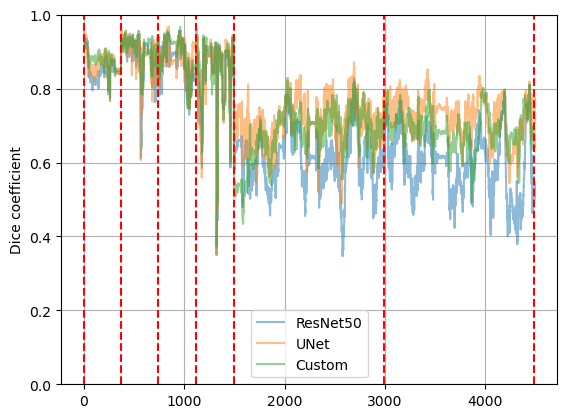

In [18]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(results2, label = "ResNet50", alpha = 0.5)
ax.plot(results, label = "UNet", alpha = 0.5)
ax.plot(results3, label = "Custom", alpha = 0.5)
for idx in range(len(INDEXES)):
    ax.axvline(INDEXES[idx], 0, 1, color = "red", linestyle = "dashed")
    if idx != len(INDEXES)-1:
        for r in (results2, results, results3):
            print(f"Average coeff: {np.average(r[INDEXES[idx]:INDEXES[idx+1]+1]):.4f} +/- {np.std(r[INDEXES[idx]:INDEXES[idx+1]+1]):.4f}")
        print("------------")

ax.set_axisbelow(True)
ax.set_ylim([0.0, 1.0])
ax.set_ylabel("Dice coefficient")
# ax.set_xticklabels([])
ax.legend()
ax.grid()

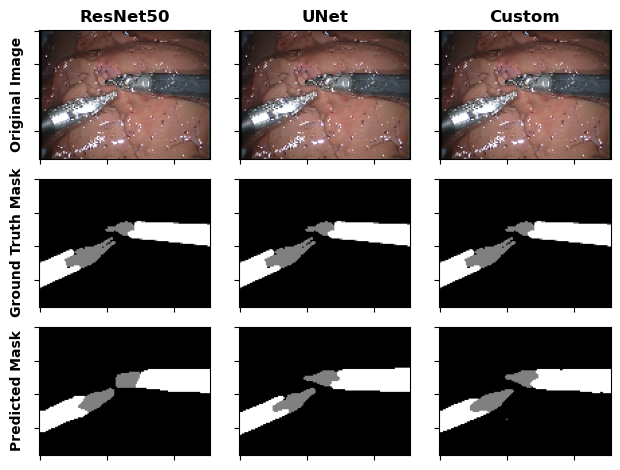

In [19]:
%matplotlib inline
fig, ax = plt.subplots(3, 3)
# im_source, im_target = get_random_image(dataset)
im_source, im_target = dataset[86]

ax[0,0].set_ylabel("Original Image", rotation = 90, fontweight = 'bold')
ax[1,0].set_ylabel("Ground Truth Mask", rotation = 90, fontweight = 'bold')
ax[2,0].set_ylabel("Predicted Mask", rotation = 90, fontweight = 'bold')

ax[0,0].set_title("ResNet50", fontweight = 'bold')
ax[0,1].set_title("UNet", fontweight = 'bold')
ax[0,2].set_title("Custom", fontweight = 'bold')

for i, model in enumerate((resnet50, unet, custom)):
    ax[0, i].imshow(reshape_to_rgb(im_source))
    ax[1, i].imshow(to_n_channel_pred_single(im_target.data.cpu()), cmap = "gray")
    ax[2, i].imshow(model.predict(im_source), cmap = "gray")
    for ii in range(3):
        ax[ii, i].set_xticklabels([])
        ax[ii, i].set_yticklabels([])
        

plt.tight_layout()
# ax[0,0].tick_params(axis = 'y', labelrotation = 90)

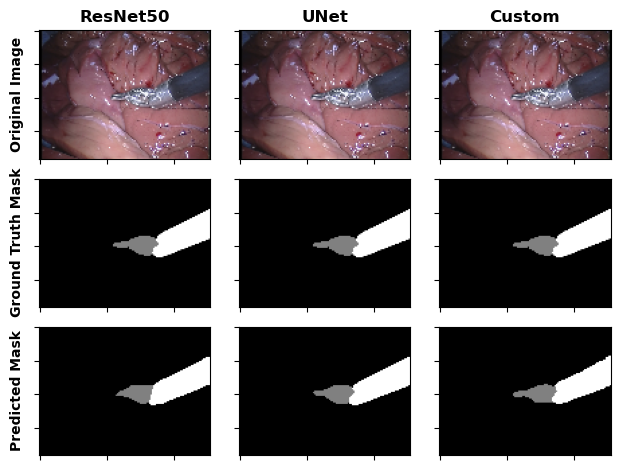

In [20]:
%matplotlib inline
fig, ax = plt.subplots(3, 3)
# im_source, im_target = get_random_image(dataset)
im_source, im_target = dataset[547]

ax[0,0].set_ylabel("Original Image", rotation = 90, fontweight = 'bold')
ax[1,0].set_ylabel("Ground Truth Mask", rotation = 90, fontweight = 'bold')
ax[2,0].set_ylabel("Predicted Mask", rotation = 90, fontweight = 'bold')

ax[0,0].set_title("ResNet50", fontweight = 'bold')
ax[0,1].set_title("UNet", fontweight = 'bold')
ax[0,2].set_title("Custom", fontweight = 'bold')

for i, model in enumerate((resnet50, unet, custom)):
    ax[0, i].imshow(reshape_to_rgb(im_source))
    ax[1, i].imshow(to_n_channel_pred_single(im_target.data.cpu()), cmap = "gray")
    ax[2, i].imshow(model.predict(im_source), cmap = "gray")
    for ii in range(3):
        ax[ii, i].set_xticklabels([])
        ax[ii, i].set_yticklabels([])
        

plt.tight_layout()
# ax[0,0].tick_params(axis = 'y', labelrotation = 90)

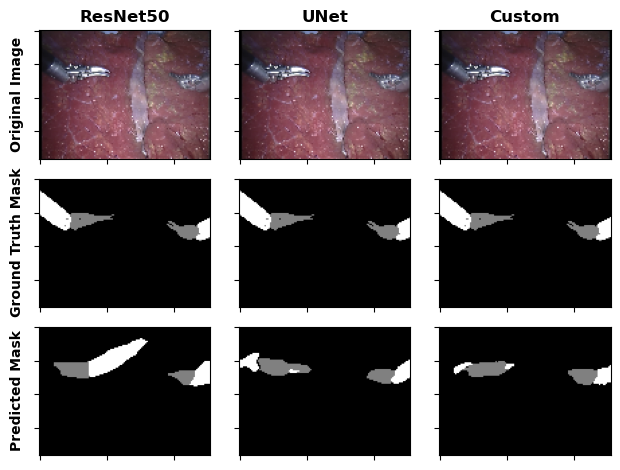

In [21]:
%matplotlib inline
fig, ax = plt.subplots(3, 3)
# im_source, im_target = get_random_image(dataset)
im_source, im_target = dataset[2581]

ax[0,0].set_ylabel("Original Image", rotation = 90, fontweight = 'bold')
ax[1,0].set_ylabel("Ground Truth Mask", rotation = 90, fontweight = 'bold')
ax[2,0].set_ylabel("Predicted Mask", rotation = 90, fontweight = 'bold')

ax[0,0].set_title("ResNet50", fontweight = 'bold')
ax[0,1].set_title("UNet", fontweight = 'bold')
ax[0,2].set_title("Custom", fontweight = 'bold')

for i, model in enumerate((resnet50, unet, custom)):
    ax[0, i].imshow(reshape_to_rgb(im_source))
    ax[1, i].imshow(to_n_channel_pred_single(im_target.data.cpu()), cmap = "gray")
    ax[2, i].imshow(model.predict(im_source), cmap = "gray")
    for ii in range(3):
        ax[ii, i].set_xticklabels([])
        ax[ii, i].set_yticklabels([])
        

plt.tight_layout()
# ax[0,0].tick_params(axis = 'y', labelrotation = 90)